In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all cvisualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [2]:
df = pd.read_csv("../data/titan_data_indicators.csv")
df.head()

,Symbol,High,Low,Open Price,Close Price,Average Trading Price,Total Traded Quantity,52 Week Low,52 Week High,SMA,EWMA5,MiddleBand,UpperBand,LowerBand,RSI,MFI,ForceIndex,ATR,EMV
0,TITAN,2910.00,2559.25,2603.05,2906.95,2727.80,31523699,1825.05,2791.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TITAN,1621.35,1267.00,1301.95,1542.35,1423.23,98999526,720.90,1341.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.350948e+11,352.550,NaN
2,TITAN,1621.35,1300.35,1331.00,1489.95,1467.88,86624727,720.90,1375.00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-4.539136e+09,337.675,-227856.456936
3,TITAN,1621.35,1343.50,1347.95,1517.30,1495.92,81710964,720.90,1392.05,NaN,1685.384615,NaN,NaN,NaN,6.929313,NaN,2.234795e+09,299.425,6757.758838
4,TITAN,1621.35,1415.55,1430.00,1450.10,1507.99,76317476,720.90,1440.55,1781.33,1595.062085,1781.33,3041.670939,520.989061,5.169155,NaN,-5.128534e+09,241.825,8525.486900


In [3]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

In [7]:
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'High',"Average Trading Price",'52 Week Low','52 Week High','MiddleBand','LowerBand','UpperBand']
temp = df
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'Low', 'High',"Average Trading Price",'MiddleBand','LowerBand','UpperBand','Date']
drop_cols = ['Low']

train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

In [8]:
train_df.head()

,Close Price,SMA,EWMA5,RSI,MFI,ForceIndex,ATR,EMV
0,2906.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1542.35,NaN,NaN,NaN,NaN,-1.350948e+11,352.550,NaN
2,1489.95,NaN,NaN,0.000000,NaN,-4.539136e+09,337.675,-227856.456936
3,1517.30,NaN,1685.384615,6.929313,NaN,2.234795e+09,299.425,6757.758838
4,1450.10,1781.33,1595.062085,5.169155,NaN,-5.128534e+09,241.825,8525.486900


In [9]:

cols = ["Close Price"]
y_train = train_df['Close Price'].copy()
X_train = train_df.drop(columns=cols)

y_valid = valid_df['Close Price'].copy()
X_valid = valid_df.drop(columns=cols)

y_test  = test_df['Close Price'].copy()
X_test  = test_df.drop(columns=cols)
True
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SMA         22 non-null     float64
 1   EWMA5       23 non-null     float64
 2   RSI         24 non-null     float64
 3   MFI         13 non-null     float64
 4   ForceIndex  25 non-null     float64
 5   ATR         25 non-null     float64
 6   EMV         24 non-null     float64
dtypes: float64(7)
memory usage: 1.6 KB


In [10]:
# TODO: FIX THE WARNINGS

parameters = {
    'n_estimators': range(100,1000,100),#500
    'learning_rate': [0.001, 0.005, 0.01, 0.05] ,#0.05
    'max_depth': [8, 10, 12, 15,20,32,64], #8
    'gamma': [0.001, 0.005, 0.01, 0.02],#0.001
    'random_state': [42]
}
','
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False,random_state=42,silent=True)
clf = GridSearchCV(model, parameters,verbose=False)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[17:30:19] WARNING: ../src/learner.cc

KeyboardInterrupt: 

In [14]:
parameters = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    # 'gamma':0.001,
    'random_state': 42
}

model = xgb.XGBRegressor(**parameters, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

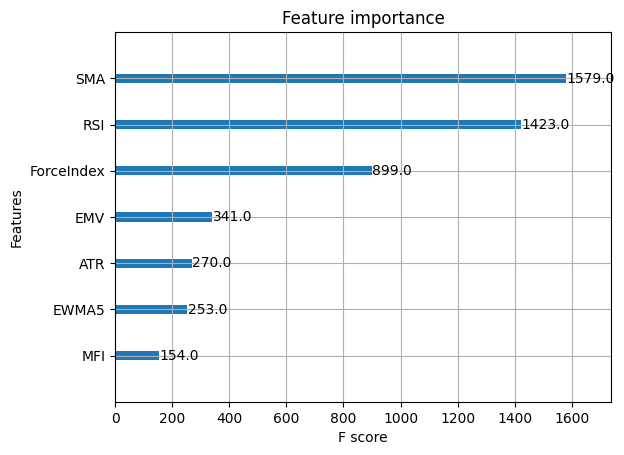

In [15]:
plot_importance(model)

In [16]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')


y_true = [1876.8  1822.55 2033.9  2055.7  2085.85]
y_pred = [1691.5651 1655.503  1717.2456 1731.5422 1731.5422]


In [17]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 78619.78346974775


In [18]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close Price'] = y_pred
predicted_prices.head()

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df['Close Price'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices['Close Price'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_pred,
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()